In [69]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

from tqdm import tqdm_notebook as tqdm
from copy import copy, deepcopy
from tensorflow.keras import datasets, layers, models, Sequential
from skimage import color

from utils import *
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint, TensorBoard
BATCH_SIZE = 16

In [70]:
load_data = tfds.load("cifar10")
train, test = load_data["train"], load_data["test"]

rgb_images = [np.array(data["image"])
                for data in train]

lab_images = [np.array(cv2.cvtColor(rgb_img, cv2.COLOR_RGB2LAB))
                for rgb_img in rgb_images]

In [71]:
def data_generator(images):
    for image in images:
        try:
            lab_image = np.array(cv2.cvtColor(image, cv2.COLOR_RGB2LAB))
            yield lab_image[:,:,0], lab_image[:,:,1], lab_image[:,:,2]
        except cv2.error:
            print("/!\\ CV2 ERROR /!\\")

In [72]:
N_BINS = 313

from tensorflow.keras.layers import *
class Model(tf.keras.Model):
    def __init__(self):
        super(Model, self).__init__()
        #print(self.dtype)
        ############################
        #########  Conv 1  #########
        ############################

        # (batch_size, 32, 32, 1) --> (batch_size, 16, 16, 8)
        self.conv_1_1 = Conv2D(filters=8, kernel_size=3,
                               padding='same',
                               activation='relu',
                               input_shape=(32, 32, 1))
        self.conv_1_2 = Conv2D(filters=8, kernel_size=3,
                               strides=(2, 2),
                               padding='same',
                               activation='relu')
        self.bn_1 = BatchNormalization()

        ############################
        #########  Conv 2  #########
        ############################

        # (batch_size, 16, 16, 8) --> (batch_size, 8, 8, 16)
        self.conv_2_1 = Conv2D(filters=16, kernel_size=3,
                               padding='same',
                               activation='relu')
        self.conv_2_2 = Conv2D(filters=16, kernel_size=3,
                               strides=(2, 2),
                               padding='same',
                               activation='relu')
        self.bn_2 = BatchNormalization()

        ############################
        #########  Conv 3  #########
        ############################

        # (batch_size, 8, 8, 16)  --> (batch_size, 4, 4, 32)
        self.conv_3_1 = layers.Conv2D(filters=32, kernel_size=3,
                                      padding='same',
                                      activation='relu')
        self.conv_3_2 = layers.Conv2D(filters=32, kernel_size=3,
                                      padding='same',
                                      activation='relu')
        self.conv_3_3 = layers.Conv2D(filters=32, kernel_size=3,
                                      strides=(2, 2),
                                      padding='same',
                                      activation='relu')
        self.bn_3 = BatchNormalization()

        ############################
        #########  Conv 4  #########
        ############################

        # (batch_size, 4, 4, 32) --> (batch_size, 4, 4, 64)
        self.conv_4_1 = Conv2D(filters=64, kernel_size=3,
                               strides=(1, 1),
                               padding='same',
                               activation='relu')
        self.conv_4_2 = Conv2D(filters=64, kernel_size=3,
                               strides=(1, 1),
                               padding='same',
                               activation='relu')
        self.conv_4_3 = Conv2D(filters=64, kernel_size=3,
                               strides=(1, 1),
                               padding='same',
                               activation='relu')
        self.bn_4 = BatchNormalization()

        ############################
        #########  Conv 5  #########
        ############################

        # (batch_size, 4, 4, 64) --> (batch_size, 4, 4, 64)
        self.conv_5_1 = Conv2D(filters=64, kernel_size=3,
                               strides=(1, 1),
                               padding='same',
                               activation='relu',
                               dilation_rate=2)
        self.conv_5_2 = Conv2D(filters=64, kernel_size=3,
                               strides=(1, 1),
                               padding='same',
                               activation='relu',
                               dilation_rate=2)
        self.conv_5_3 = Conv2D(filters=64, kernel_size=3,
                               strides=(1, 1),
                               padding='same',
                               activation='relu',
                               dilation_rate=2)
        self.bn_5 = BatchNormalization()

        ############################
        #########  Conv 6  #########
        ############################

        # (batch_size, 4, 4, 64) --> (batch_size, 4, 4, 64)
        self.conv_6_1 = Conv2D(filters=64, kernel_size=3,
                               padding='same',
                               activation='relu',
                               dilation_rate=2)
        self.conv_6_2 = Conv2D(filters=64, kernel_size=3,
                               padding='same',
                               activation='relu',
                               dilation_rate=2)
        self.conv_6_3 = Conv2D(filters=64, kernel_size=3,
                                  padding='same',
                                  activation='relu',
                                  dilation_rate=2)
        self.bn_6 = BatchNormalization()

        ############################
        #########  Conv 7  #########
        ############################

        # (batch_size, 4, 4, 64) --> (batch_size, 4, 4, 64)
        self.conv_7_1 = Conv2D(filters=64, kernel_size=3,
                               padding='same',
                               activation='relu',
                               dilation_rate=1)
        self.conv_7_2 = Conv2D(filters=64, kernel_size=3,
                               padding='same',
                               activation='relu',
                               dilation_rate=1)
        self.conv_7_3 = Conv2D(filters=64, kernel_size=3,
                               padding='same',
                               activation='relu',
                               dilation_rate=1)
        self.bn_7 = BatchNormalization()

        ############################
        #########  Deconv  #########
        ############################

        # (batch_size, 4, 4, 64) --> (batch_size, 32, 32, 32)
        self.deconv_1_1 = Conv2DTranspose(filters=32, kernel_size=4,
                                          strides=(2, 2),
                                          padding='same',
                                          activation='relu',
                                          dilation_rate=1)
        self.deconv_1_2 = Conv2DTranspose(filters=32, kernel_size=3,
                                          strides=(2, 2),
                                          padding='same',
                                          activation='relu',
                                          dilation_rate=1)
        self.deconv_1_3 = Conv2DTranspose(filters=32, kernel_size=3,
                                          strides=(2, 2),
                                          padding='same',
                                          activation='relu',
                                          dilation_rate=1)

        ############################
        ####  Unary prediction  ####
        ############################

        # (batch_size, 32, 32, 32) --> (batch_size, 32, 32, 1)
        self.conv_a = Conv2D(filters=1,
                             kernel_size=1,
                             strides=(1, 1),
                             dilation_rate=1)
        self.conv_b = Conv2D(filters=1,
                             kernel_size=1,
                             strides=(1, 1),
                             dilation_rate=1)
        
        self.seq_layers = [self.conv_1_1, self.conv_1_2, self.bn_1,
                           self.conv_2_1, self.conv_2_2, self.bn_2,
                           self.conv_3_1, self.conv_3_2, self.conv_3_3, self.bn_3,
                           self.conv_4_1, self.conv_4_2, self.conv_4_3, self.bn_4,
                           self.conv_5_1, self.conv_5_2, self.conv_5_3, self.bn_5,
                           self.conv_6_1, self.conv_6_2, self.conv_6_3, self.bn_6,
                           self.conv_7_1, self.conv_7_2, self.conv_7_3, self.bn_7,
                           self.deconv_1_1, self.deconv_1_2, self.deconv_1_3]

    def call(self, inputs):
        x = inputs
        for layer in self.seq_layers:
            x = layer(x)
        probs_a = self.conv_a(x)
        probs_b = self.conv_b(x)
        return probs_a, probs_b
        
model = Model()

In [5]:
model.build((1,32,32,1))

In [73]:
train_loss = tf.keras.metrics.Mean()
train_accuracy_a = tf.keras.metrics.MeanSquaredError(name='train_accuracy_a')
train_accuracy_b = tf.keras.metrics.MeanSquaredError(name='train_accuracy_b')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy_a = tf.keras.metrics.MeanSquaredError(name='test_accuracy_a')
test_accuracy_b = tf.keras.metrics.MeanSquaredError(name='test_accuracy_b')
loss_object = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam()

@tf.function
def train_step(image, labels_a, labels_b):
    with tf.GradientTape() as tape:
        probs_a, probs_b = model(image)
        loss_a = loss_object(labels_a, probs_a)
        loss_b = loss_object(labels_b, probs_b)
        loss = loss_a + loss_b
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    train_loss(loss)
    train_accuracy_a(labels_a, probs_a)
    train_accuracy_b(labels_b, probs_b)
    
@tf.function
def test_step(image, labels_a, labels_b):
    probs_a, probs_b = model(image)
    t_loss_a = loss_object(labels_a, probs_a)
    t_loss_b = loss_object(labels_b, probs_b)
    t_loss = t_loss_a + t_loss_b

    test_loss(t_loss)
    test_accuracy_a(labels_a, probs_a)
    test_accuracy_b(labels_b, probs_b)

In [74]:
def train_generator():
    gen = data_generator(rgb_images)
    for features, labels_a, labels_b in gen:
        inputs = []
        targets_a = []
        targets_b = []
        for i in range(BATCH_SIZE):
            #print(np.expand_dims(labels, -1)[:,:,0].shape)
            inputs.append(np.expand_dims(features, -1))
            targets_a.append(np.expand_dims(labels_a, -1))
            targets_b.append(np.expand_dims(labels_b, -1))
        yield np.array(inputs).astype('float32'), \
                np.array(targets_a).astype('float32'), \
                    np.array(targets_b).astype('float32')

In [75]:
train_gen = train_generator()

In [94]:
for index, (batch_luminance, batch_a, batch_b) in enumerate(train_gen):
    hh=np.concatenate([batch_luminance, batch_a, batch_b],axis=3).astype('int')
    #print(np.array(hh))
    kk=cv2.cvtColor(np.array(hh), cv2.COLOR_LAB2RGB)
    #plt.imshow(cv2.cvtColor(hh, cv2.COLOR_LAB2RGB)[0,:,:])
    #print(batch_luminance[0].shape)
    break

error: OpenCV(4.1.0) /Users/travis/build/skvark/opencv-python/opencv/modules/imgproc/src/color.simd_helpers.hpp:92: error: (-2:Unspecified error) in function 'cv::impl::(anonymous namespace)::CvtHelper<cv::impl::(anonymous namespace)::Set<3, -1, -1>, cv::impl::(anonymous namespace)::Set<3, 4, -1>, cv::impl::(anonymous namespace)::Set<0, 5, -1>, cv::impl::(anonymous namespace)::SizePolicy::NONE>::CvtHelper(InputArray, OutputArray, int) [VScn = cv::impl::(anonymous namespace)::Set<3, -1, -1>, VDcn = cv::impl::(anonymous namespace)::Set<3, 4, -1>, VDepth = cv::impl::(anonymous namespace)::Set<0, 5, -1>, sizePolicy = cv::impl::(anonymous namespace)::SizePolicy::NONE]'
> Invalid number of channels in input image:
>     'VScn::contains(scn)'
> where
>     'scn' is 1


In [76]:
batch_luminance, batch_a, batch_b = next(train_gen)

In [95]:
EPOCHS = 5

for epoch in range(EPOCHS):
    train_gen = train_generator()
    for index, (batch_luminance, batch_a, batch_b) in enumerate(train_gen):
        train_step(batch_luminance, batch_a, batch_b)
        if index%1000==0:
            print('Epoch {}, iteration {}'.format(epoch, index))
    print('Epoch {} is done'.format(epoch))
            #print(template.format(epoch + 1,
            #                      round(float(train_loss.result()), 3),
            #                      round(float(train_accuracy_a.result()) * 100, 2),
            #                      round(float(train_accuracy_b.result()) * 100, 2)))

Epoch 0, iteration 0
Epoch 0, iteration 1000
Epoch 0, iteration 2000
Epoch 0, iteration 3000
Epoch 0, iteration 4000
Epoch 0, iteration 5000
Epoch 0, iteration 6000
Epoch 0, iteration 7000
Epoch 0, iteration 8000
Epoch 0, iteration 9000
Epoch 0, iteration 10000
Epoch 0, iteration 11000
Epoch 0, iteration 12000
Epoch 0, iteration 13000
Epoch 0, iteration 14000
Epoch 0, iteration 15000
Epoch 0, iteration 16000
Epoch 0, iteration 17000
Epoch 0, iteration 18000
Epoch 0, iteration 19000
Epoch 0, iteration 20000
Epoch 0, iteration 21000
Epoch 0, iteration 22000
Epoch 0, iteration 23000
Epoch 0, iteration 24000
Epoch 0, iteration 25000
Epoch 0, iteration 26000
Epoch 0, iteration 27000
Epoch 0, iteration 28000
Epoch 0, iteration 29000
Epoch 0, iteration 30000
Epoch 0, iteration 31000
Epoch 0, iteration 32000
Epoch 0, iteration 33000
Epoch 0, iteration 34000
Epoch 0, iteration 35000
Epoch 0, iteration 36000
Epoch 0, iteration 37000
Epoch 0, iteration 38000
Epoch 0, iteration 39000
Epoch 0, iter

In [98]:
model.save_weights('model_regression.h5')

In [ ]:
train_gen = train_generator()

In [192]:
def test_output(train_gen):
    fig, axes = plt.subplots(1,3, figsize=(16,16))
    lums, real_probs_a, real_probs_b = next(train_gen)
    lum = lums[0]
    real_prob_a = real_probs_a[0]
    real_prob_b = real_probs_b[0]
    
    pred_probs_a, pred_probs_b = model(lum.reshape(1,32,32,1))
    real_lab=np.concatenate([lum.reshape(1,32,32,1),
                             real_prob_a.reshape(1,32,32,1),
                             real_prob_b.reshape(1,32,32,1)], axis=3).astype('uint8')
    pred_lab=np.concatenate([lum.reshape(1,32,32,1),
                             np.array(pred_probs_a).reshape(1,32,32,1),
                             np.array(pred_probs_b).reshape(1,32,32,1)], axis=3).astype('uint8')
    real_rgb=cv2.cvtColor(real_lab[0], cv2.COLOR_LAB2RGB)
    pred_rgb=cv2.cvtColor(pred_lab[0], cv2.COLOR_LAB2RGB)
    axes[0].imshow(real_rgb)
    axes[1].imshow(lum.reshape(32,32),cmap='gray')
    axes[2].imshow(pred_rgb)

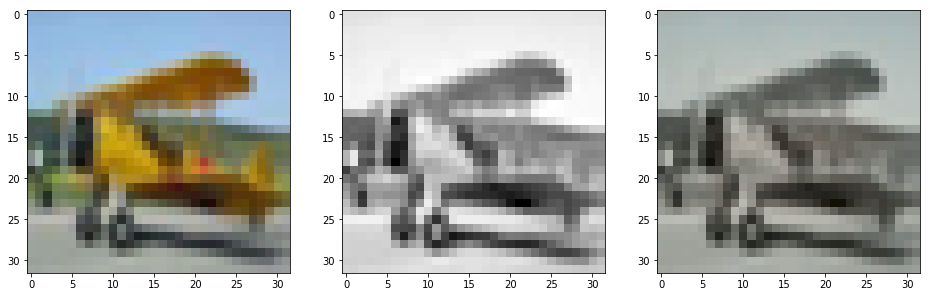

In [193]:
test_output(train_gen)